<center><h1>Nguyen_Vu_HW7</h1></center>

Name: Vu Nguyen
<br>
Github Username: nguyenlamvu88
<br>
USC ID: 2120314402

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer, label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, hamming_loss, classification_report, confusion_matrix,
    precision_score, recall_score, roc_auc_score, make_scorer, silhouette_score
)
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from scipy.spatial.distance import hamming


### (a) Download the Anuran Calls (MFCCs) Data Set

In [3]:
# Load dataset
file_path = '../data/Frogs_MFCCs.csv'  
df = pd.read_csv(file_path)

# Check for missing data
missing_data_summary = df.isnull().sum()
missing_data_summary = missing_data_summary[missing_data_summary > 0]

if not missing_data_summary.empty:
    print("Missing data found. Imputing missing values with column means...")
    # Impute missing values with the mean of each column
    df.fillna(df.mean(), inplace=True)
else:
    print("No missing data found. Proceeding with data processing...")

# Extract features (MFCC columns) and labels
X = df.filter(regex="MFCCs_")  # Selects columns starting with 'MFCCs_' for features
y_family = df['Family']
y_genus = df['Genus']
y_species = df['Species']

# Encode labels to numerical values
le_family = LabelEncoder()
le_genus = LabelEncoder()
le_species = LabelEncoder()

y_family_encoded = le_family.fit_transform(y_family)
y_genus_encoded = le_genus.fit_transform(y_genus)
y_species_encoded = le_species.fit_transform(y_species)

# Combine encoded labels into a multi-label target
y_combined = pd.DataFrame({
    'Family': y_family_encoded,
    'Genus': y_genus_encoded,
    'Species': y_species_encoded
})

# Split data into train (70%) and test (30%) sets
X_train, X_test, y_train_combined, y_test_combined = train_test_split(
    X, y_combined, test_size=0.3, random_state=42
)

# Confirm the split sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


No missing data found. Proceeding with data processing...
Training set size: 5036 samples
Test set size: 2159 samples


### (b) Train a classifier for each label

#### (i) Research

#### Evaluation Metrics for Multi-Label Classification

###### 1. Exact Match (Subset Accuracy)
The Exact Match metric, also known as **Subset Accuracy**, requires all labels for an instance (e.g., Family, Genus, Species) to match exactly between the model’s prediction and the true labels. The **Exact Match Score** is the proportion of instances where all labels are correct. A score of 1 indicates perfect predictions for all instances, while 0 means none were exactly correct.

###### Formula
$$
\text{Exact Match Score} = \frac{1}{N} \sum_{i=1}^{N} 1(y_i = \hat{y}_i)
$$
where:
- $N$ is the number of instances,
- $y_i$ is the true set of labels,
- $\hat{y}_i$ is the predicted set of labels,
- $1(\cdot)$ is an indicator function that returns 1 if the condition is true and 0 otherwise.

###### 2. Hamming Score and Hamming Loss
The **Hamming Score** and **Hamming Loss** provide a more flexible assessment by evaluating each label individually, allowing partial matches. This is especially useful in multi-label classification.

###### Hamming Score
The Hamming Score is the average fraction of correctly predicted labels across instances:
$$
\text{Hamming Score} = \frac{1}{N} \sum_{i=1}^{N} \frac{\text{Number of correct labels for instance } i}{\text{Total labels for instance } i}
$$

###### Hamming Loss
The Hamming Loss is the average fraction of incorrect labels per instance:
$$
\text{Hamming Loss} = \frac{1}{N} \sum_{i=1}^{N} \frac{\text{Number of incorrect labels for instance } i}{\text{Total labels for instance } i}
$$

###### Interpretation
- A **lower Hamming Loss** and **higher Hamming Score** indicate better performance.
- A **Hamming Loss of 0** means all labels were predicted correctly.

##### Selection
- Hamming Score/Loss provides a balanced evaluation by rewarding correct predictions on individual labels without requiring all labels to be correct at once. This flexibility supports incremental model improvements and offers more useful insights.


#### (ii) Train a SVM for each of the labels

#### - Binary Relevance
- Trained separate SVMs for each label (Family, Genus, Species) using Gaussian kernels.

##### - Evaluation Metrics
- Used **Exact Match Score** (strict) and **Hamming Score** (lenient) to assess accuracy.

##### Parameter Tuning
- Identified feasible ranges for $C$ and $\gamma$ based on a 70% training accuracy threshold, then applied cross-validation on a refined grid with logarithmic increments for $C$ and linear increments for $\gamma$.

##### - Standardized vs. Raw Features
- Compared model performance with standardized and raw features using the evaluation metrics, identifying the impact of feature scaling.

##### - Results
- Reported **Exact Match**, **Hamming Loss**, and **Hamming Score** for each setup, highlighting accuracy and feature scaling effects.


In [4]:
# Load dataset and handle missing data if necessary
file_path = '../data/Frogs_MFCCs.csv'  
df = pd.read_csv(file_path)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Extract features and labels
X = df.filter(regex="MFCCs_")
y_family = df['Family']
y_genus = df['Genus']
y_species = df['Species']

# Encode labels to numerical values
le_family = LabelEncoder()
le_genus = LabelEncoder()
le_species = LabelEncoder()

y_family_encoded = le_family.fit_transform(y_family)
y_genus_encoded = le_genus.fit_transform(y_genus)
y_species_encoded = le_species.fit_transform(y_species)

# Combine labels for multi-label classification
y_combined = pd.DataFrame({
    'Family': y_family_encoded,
    'Genus': y_genus_encoded,
    'Species': y_species_encoded
})

# Define evaluation function for exact match
def exact_match(y_true, y_pred):
    matches = (y_true == y_pred).all(axis=1)
    return np.mean(matches)

# Step 1: Data Partitioning - 70% training, 30% testing
X_train, X_test, y_train_combined, y_test_combined = train_test_split(
    X, y_combined, test_size=0.3, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Set initial parameter ranges for hyperparameter tuning
C_initial = np.logspace(-3, 6, num=10)  # Large range for penalty (C)
gamma_initial = np.linspace(0.1, 10, num=10)  # Large range for kernel width (gamma)

# Step 3: Determine bounds for C and gamma using training accuracy threshold
def find_bounds(X_train, y_train, C_values, gamma_values, threshold=0.7):
    """
    This function tests combinations of C and gamma to find parameter bounds
    where the training accuracy is above the specified threshold.
    """
    valid_C = set()
    valid_gamma = set()
    for C in C_values:
        for gamma in gamma_values:
            svm = SVC(kernel='rbf', class_weight='balanced', C=C, gamma=gamma)
            svm.fit(X_train, y_train)
            train_accuracy = svm.score(X_train, y_train)
            print(f"C={C}, gamma={gamma} -> Training Accuracy: {train_accuracy:.4f}")
            if train_accuracy >= threshold:
                valid_C.add(C)
                valid_gamma.add(gamma)
    if valid_C and valid_gamma:
        return min(valid_C), max(valid_C), min(valid_gamma), max(valid_gamma)
    else:
        return min(C_values), max(C_values), min(gamma_values), max(gamma_values)

# Determine bounds for C and gamma for each label
print("\nDetermining parameter bounds for 'Family' label:")
C_min_family, C_max_family, gamma_min_family, gamma_max_family = find_bounds(
    X_train_scaled, y_train_combined['Family'], C_initial, gamma_initial
)

print("\nDetermining parameter bounds for 'Genus' label:")
C_min_genus, C_max_genus, gamma_min_genus, gamma_max_genus = find_bounds(
    X_train_scaled, y_train_combined['Genus'], C_initial, gamma_initial
)

print("\nDetermining parameter bounds for 'Species' label:")
C_min_species, C_max_species, gamma_min_species, gamma_max_species = find_bounds(
    X_train_scaled, y_train_combined['Species'], C_initial, gamma_initial
)

# Step 4: Define refined parameter grids for cross-validation for each label
param_grid_family = {
    'C': np.logspace(np.log10(C_min_family), np.log10(C_max_family), 10),
    'gamma': np.linspace(gamma_min_family, gamma_max_family, 10)
}

param_grid_genus = {
    'C': np.logspace(np.log10(C_min_genus), np.log10(C_max_genus), 10),
    'gamma': np.linspace(gamma_min_genus, gamma_max_genus, 10)
}

param_grid_species = {
    'C': np.logspace(np.log10(C_min_species), np.log10(C_max_species), 10),
    'gamma': np.linspace(gamma_min_species, gamma_max_species, 10)
}

# Step 5: Train and evaluate each label’s classifier with SVMs and Gaussian kernels
def train_and_evaluate_svm(X_train, y_train, X_test, y_test, label, param_grid):
    """
    This function performs GridSearchCV with a Gaussian kernel and one-vs-all
    strategy to find the best SVM parameters for each label. It also evaluates
    the classifier using various metrics.
    """
    # Set up SVM with RBF kernel and one-vs-all strategy
    svm = SVC(kernel='rbf', decision_function_shape='ovr', class_weight='balanced', probability=False)
    grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')  # 10-fold cross-validation
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Binarize labels for ROC AUC computation
    classes = np.unique(y_train)
    y_test_binarized = label_binarize(y_test, classes=classes)
    y_score = best_model.decision_function(X_test)

    # Evaluation Metrics
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)

    # Compute ROC AUC Score safely
    if len(classes) > 2:
        # Multiclass case
        roc_auc = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
    else:
        # Binary case
        roc_auc = roc_auc_score(y_test_binarized, y_score)

    # Print Metrics for Each Label
    print(f"\n--- Evaluation Results for {label} ---")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Confusion Matrix:\n{confusion}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"ROC AUC (Macro): {roc_auc:.4f}")

    return y_pred

# Train and evaluate for each label (Binary Relevance)
print("\nTraining and evaluating 'Family' classifier:")
y_pred_family = train_and_evaluate_svm(
    X_train_scaled, y_train_combined['Family'],
    X_test_scaled, y_test_combined['Family'],
    "Family",
    param_grid_family
)

print("\nTraining and evaluating 'Genus' classifier:")
y_pred_genus = train_and_evaluate_svm(
    X_train_scaled, y_train_combined['Genus'],
    X_test_scaled, y_test_combined['Genus'],
    "Genus",
    param_grid_genus
)

print("\nTraining and evaluating 'Species' classifier:")
y_pred_species = train_and_evaluate_svm(
    X_train_scaled, y_train_combined['Species'],
    X_test_scaled, y_test_combined['Species'],
    "Species",
    param_grid_species
)

# Combine predictions for overall evaluation
y_pred_combined = np.vstack((y_pred_family, y_pred_genus, y_pred_species)).T
y_test_combined_array = y_test_combined.to_numpy()

# Overall Evaluation
exact_match_score = exact_match(y_test_combined_array, y_pred_combined)

# Compute Hamming loss manually for multi-class, multi-label setting
incorrect_labels = np.sum(y_test_combined_array != y_pred_combined)
total_labels = y_test_combined_array.size
hamming_loss_score = incorrect_labels / total_labels
hamming_score_value = 1 - hamming_loss_score

# Print Overall Evaluation Metrics
print("\n--- Overall Evaluation Results ---")
print(f"Exact Match Score: {exact_match_score:.4f}")
print(f"Hamming Loss: {hamming_loss_score:.4f}")
print(f"Hamming Score: {hamming_score_value:.4f}")



Determining parameter bounds for 'Family' label:
C=0.001, gamma=0.1 -> Training Accuracy: 0.0820
C=0.001, gamma=1.2000000000000002 -> Training Accuracy: 0.0755
C=0.001, gamma=2.3000000000000003 -> Training Accuracy: 0.0755
C=0.001, gamma=3.4000000000000004 -> Training Accuracy: 0.0755
C=0.001, gamma=4.5 -> Training Accuracy: 0.0755
C=0.001, gamma=5.6 -> Training Accuracy: 0.0755
C=0.001, gamma=6.7 -> Training Accuracy: 0.0755
C=0.001, gamma=7.800000000000001 -> Training Accuracy: 0.0755
C=0.001, gamma=8.9 -> Training Accuracy: 0.0755
C=0.001, gamma=10.0 -> Training Accuracy: 0.0755
C=0.01, gamma=0.1 -> Training Accuracy: 0.8975
C=0.01, gamma=1.2000000000000002 -> Training Accuracy: 0.7240
C=0.01, gamma=2.3000000000000003 -> Training Accuracy: 0.3124
C=0.01, gamma=3.4000000000000004 -> Training Accuracy: 0.3124
C=0.01, gamma=4.5 -> Training Accuracy: 0.3124
C=0.01, gamma=5.6 -> Training Accuracy: 0.3124
C=0.01, gamma=6.7 -> Training Accuracy: 0.3124
C=0.01, gamma=7.800000000000001 -> T

C=100.0, gamma=1.2000000000000002 -> Training Accuracy: 1.0000
C=100.0, gamma=2.3000000000000003 -> Training Accuracy: 1.0000
C=100.0, gamma=3.4000000000000004 -> Training Accuracy: 1.0000
C=100.0, gamma=4.5 -> Training Accuracy: 1.0000
C=100.0, gamma=5.6 -> Training Accuracy: 1.0000
C=100.0, gamma=6.7 -> Training Accuracy: 1.0000
C=100.0, gamma=7.800000000000001 -> Training Accuracy: 1.0000
C=100.0, gamma=8.9 -> Training Accuracy: 1.0000
C=100.0, gamma=10.0 -> Training Accuracy: 1.0000
C=1000.0, gamma=0.1 -> Training Accuracy: 1.0000
C=1000.0, gamma=1.2000000000000002 -> Training Accuracy: 1.0000
C=1000.0, gamma=2.3000000000000003 -> Training Accuracy: 1.0000
C=1000.0, gamma=3.4000000000000004 -> Training Accuracy: 1.0000
C=1000.0, gamma=4.5 -> Training Accuracy: 1.0000
C=1000.0, gamma=5.6 -> Training Accuracy: 1.0000
C=1000.0, gamma=6.7 -> Training Accuracy: 1.0000
C=1000.0, gamma=7.800000000000001 -> Training Accuracy: 1.0000
C=1000.0, gamma=8.9 -> Training Accuracy: 1.0000
C=1000.0


--- Evaluation Results for Family ---
Best Parameters: {'C': 35.93813663804626, 'gamma': 0.1}
Confusion Matrix:
[[  24    0    3    0]
 [   0  162    0    0]
 [   0    0  621    2]
 [   0    0   11 1336]]
Precision (Macro): 0.9941
Recall (Macro): 0.9694
ROC AUC (Macro): 0.9970

Training and evaluating 'Genus' classifier:

--- Evaluation Results for Genus ---
Best Parameters: {'C': 35.93813663804626, 'gamma': 0.1}
Confusion Matrix:
[[1245    0    0    5    0    1    0    0]
 [   0  162    0    0    0    0    0    0]
 [   1    0   81    2    0    0    0    0]
 [   0    0    0  467    0    1    0    0]
 [   0    0    0    3   92    1    0    0]
 [   0    0    0    6    0   28    0    0]
 [   0    0    0    3    0    0   24    0]
 [   0    0    0    3    0    0    0   34]]
Precision (Macro): 0.9822
Recall (Macro): 0.9434
ROC AUC (Macro): 0.9872

Training and evaluating 'Species' classifier:

--- Evaluation Results for Species ---
Best Parameters: {'C': 35.93813663804626, 'gamma': 0.1}
Con

#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [5]:
# Load dataset and handle missing data if necessary
file_path = '../data/Frogs_MFCCs.csv'  
df = pd.read_csv(file_path)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Extract features and labels
X = df.filter(regex="MFCCs_")
y_family = df['Family']
y_genus = df['Genus']
y_species = df['Species']

# Encode labels to numerical values
le_family = LabelEncoder()
le_genus = LabelEncoder()
le_species = LabelEncoder()

y_family_encoded = le_family.fit_transform(y_family)
y_genus_encoded = le_genus.fit_transform(y_genus)
y_species_encoded = le_species.fit_transform(y_species)

# Combine labels for multi-label classification
y_combined = pd.DataFrame({
    'Family': y_family_encoded,
    'Genus': y_genus_encoded,
    'Species': y_species_encoded
})

# Define evaluation function for exact match
def exact_match(y_true, y_pred):
    matches = (y_true == y_pred).all(axis=1)
    return np.mean(matches)

# Step 1: Data Partitioning - 70% training, 30% testing
X_train, X_test, y_train_combined, y_test_combined = train_test_split(
    X, y_combined, test_size=0.3, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Set initial parameter ranges for hyperparameter tuning
C_initial = np.logspace(-3, 3, num=7)  # From 1e-3 to 1e3

# Step 3: Determine bounds for C using training accuracy threshold
def find_C_bounds(X_train, y_train, C_values, threshold=0.7):
    """
    This function tests values of C to find parameter bounds
    where the training accuracy is above the specified threshold.
    """
    valid_C = []
    for C in C_values:
        svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, class_weight='balanced', C=C, max_iter=10000)
        svm.fit(X_train, y_train)
        train_accuracy = svm.score(X_train, y_train)
        print(f"C={C} -> Training Accuracy: {train_accuracy:.4f}")
        if train_accuracy >= threshold:
            valid_C.append(C)
    if valid_C:
        return min(valid_C), max(valid_C)
    else:
        return min(C_values), max(C_values)

# Determine bounds for C for each label
print("\nDetermining parameter bounds for 'Family' label:")
C_min_family, C_max_family = find_C_bounds(X_train_scaled, y_train_combined['Family'], C_initial)

print("\nDetermining parameter bounds for 'Genus' label:")
C_min_genus, C_max_genus = find_C_bounds(X_train_scaled, y_train_combined['Genus'], C_initial)

print("\nDetermining parameter bounds for 'Species' label:")
C_min_species, C_max_species = find_C_bounds(X_train_scaled, y_train_combined['Species'], C_initial)

# Step 4: Define refined parameter grids for cross-validation for each label
param_grid_family = {
    'C': np.logspace(np.log10(C_min_family), np.log10(C_max_family), 10)
}

param_grid_genus = {
    'C': np.logspace(np.log10(C_min_genus), np.log10(C_max_genus), 10)
}

param_grid_species = {
    'C': np.logspace(np.log10(C_min_species), np.log10(C_max_species), 10)
}

# Step 5: Train and evaluate each label’s classifier with L1-penalized Linear SVMs
def train_and_evaluate_svm(X_train, y_train, X_test, y_test, label, param_grid):
    """
    This function performs GridSearchCV with L1-penalized LinearSVC
    to find the best SVM parameters for each label. It also evaluates
    the classifier using various metrics.
    """
    # Set up LinearSVC with L1 penalty
    svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, class_weight='balanced', max_iter=10000)
    grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')  # 10-fold cross-validation
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Binarize labels for ROC AUC computation
    classes = np.unique(y_train)
    y_test_binarized = label_binarize(y_test, classes=classes)
    y_score = best_model.decision_function(X_test)

    # Evaluation Metrics
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)

    # Compute ROC AUC Score safely
    if len(classes) > 2:
        # Multiclass case
        roc_auc = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
    else:
        # Binary case
        roc_auc = roc_auc_score(y_test_binarized, y_score)

    # Print Metrics for Each Label
    print(f"\n--- Evaluation Results for {label} ---")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Confusion Matrix:\n{confusion}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"ROC AUC (Macro): {roc_auc:.4f}")

    return y_pred

# Train and evaluate for each label (Binary Relevance)
print("\nTraining and evaluating 'Family' classifier:")
y_pred_family = train_and_evaluate_svm(
    X_train_scaled, y_train_combined['Family'],
    X_test_scaled, y_test_combined['Family'],
    "Family",
    param_grid_family
)

print("\nTraining and evaluating 'Genus' classifier:")
y_pred_genus = train_and_evaluate_svm(
    X_train_scaled, y_train_combined['Genus'],
    X_test_scaled, y_test_combined['Genus'],
    "Genus",
    param_grid_genus
)

print("\nTraining and evaluating 'Species' classifier:")
y_pred_species = train_and_evaluate_svm(
    X_train_scaled, y_train_combined['Species'],
    X_test_scaled, y_test_combined['Species'],
    "Species",
    param_grid_species
)

# Combine predictions for overall evaluation
y_pred_combined = np.vstack((y_pred_family, y_pred_genus, y_pred_species)).T
y_test_combined_array = y_test_combined.to_numpy()

# Overall Evaluation
exact_match_score = exact_match(y_test_combined_array, y_pred_combined)

# Compute Hamming loss manually for multi-class, multi-label setting
incorrect_labels = np.sum(y_test_combined_array != y_pred_combined)
total_labels = y_test_combined_array.size
hamming_loss_score = incorrect_labels / total_labels
hamming_score_value = 1 - hamming_loss_score

# Print Overall Evaluation Metrics
print("\n--- Overall Evaluation Results ---")
print(f"Exact Match Score: {exact_match_score:.4f}")
print(f"Hamming Loss: {hamming_loss_score:.4f}")
print(f"Hamming Score: {hamming_score_value:.4f}")



Determining parameter bounds for 'Family' label:
C=0.001 -> Training Accuracy: 0.8396
C=0.01 -> Training Accuracy: 0.9176
C=0.1 -> Training Accuracy: 0.9347
C=1.0 -> Training Accuracy: 0.9376
C=10.0 -> Training Accuracy: 0.9378
C=100.0 -> Training Accuracy: 0.9380
C=1000.0 -> Training Accuracy: 0.9380

Determining parameter bounds for 'Genus' label:
C=0.001 -> Training Accuracy: 0.8896
C=0.01 -> Training Accuracy: 0.9365
C=0.1 -> Training Accuracy: 0.9472
C=1.0 -> Training Accuracy: 0.9494
C=10.0 -> Training Accuracy: 0.9496
C=100.0 -> Training Accuracy: 0.9496
C=1000.0 -> Training Accuracy: 0.9496

Determining parameter bounds for 'Species' label:
C=0.001 -> Training Accuracy: 0.8521
C=0.01 -> Training Accuracy: 0.9502
C=0.1 -> Training Accuracy: 0.9613
C=1.0 -> Training Accuracy: 0.9653
C=10.0 -> Training Accuracy: 0.9658
C=100.0 -> Training Accuracy: 0.9660
C=1000.0 -> Training Accuracy: 0.9660

Training and evaluating 'Family' classifier:

--- Evaluation Results for Family ---
Bes

C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number 


--- Evaluation Results for Genus ---
Best Parameters: {'C': 46.41588833612773}
Confusion Matrix:
[[1190   25   14    7    0    3    9    3]
 [   3  152    5    1    0    0    1    0]
 [  10    4   65    0    0    0    4    1]
 [   7    0    0  451    2    0    3    5]
 [   0    0    1    7   85    1    2    0]
 [   1    0    0    3    0   29    1    0]
 [   1    0    0    1    1    0   24    0]
 [   0    0    0    0    0    0    3   34]]
Precision (Macro): 0.8365
Recall (Macro): 0.8966
ROC AUC (Macro): 0.9869

Training and evaluating 'Species' classifier:


C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



--- Evaluation Results for Species ---
Best Parameters: {'C': 10.0}
Confusion Matrix:
[[ 199    0   11    3    0    2    0    1    1    3]
 [   0 1029    1    0    0    0    0    0    1    0]
 [   0    0  153    5    0    3    0    0    1    0]
 [   2    6    4   67    0    0    0    0    4    1]
 [   3    0    1    0  129    1    0    0    1    0]
 [   1    1    0    0    2  323    1    0    2    3]
 [   1    0    0    1    4    2   86    0    2    0]
 [   1    0    0    0    4    1    0   27    1    0]
 [   0    0    0    0    1    0    1    0   25    0]
 [   0    0    0    0    0    0    0    0    3   34]]
Precision (Macro): 0.9011
Recall (Macro): 0.9105
ROC AUC (Macro): 0.9898

--- Overall Evaluation Results ---
Exact Match Score: 0.9064
Hamming Loss: 0.0594
Hamming Score: 0.9406


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [6]:
# Load dataset and handle missing data if necessary
file_path = '../data/Frogs_MFCCs.csv'  
df = pd.read_csv(file_path)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Extract features and labels
X = df.filter(regex="MFCCs_")
y_family = df['Family']
y_genus = df['Genus']
y_species = df['Species']

# Encode labels to numerical values
le_family = LabelEncoder()
le_genus = LabelEncoder()
le_species = LabelEncoder()

y_family_encoded = le_family.fit_transform(y_family)
y_genus_encoded = le_genus.fit_transform(y_genus)
y_species_encoded = le_species.fit_transform(y_species)

# Combine labels for multi-label classification
y_combined = pd.DataFrame({
    'Family': y_family_encoded,
    'Genus': y_genus_encoded,
    'Species': y_species_encoded
})

# Define evaluation function for exact match
def exact_match(y_true, y_pred):
    matches = (y_true == y_pred).all(axis=1)
    return np.mean(matches)

# Step 1: Data Partitioning - 70% training, 30% testing
X_train, X_test, y_train_combined, y_test_combined = train_test_split(
    X, y_combined, test_size=0.3, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to each label separately
def apply_smote(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Initialize dictionaries to store resampled data
X_train_resampled_dict = {}
y_train_resampled_dict = {}

# Apply SMOTE to each label
for label in ['Family', 'Genus', 'Species']:
    print(f"Applying SMOTE to {label} label.")
    X_resampled, y_resampled = apply_smote(X_train_scaled, y_train_combined[label])
    X_train_resampled_dict[label] = X_resampled
    y_train_resampled_dict[label] = y_resampled

# Step 2: Set initial parameter ranges for hyperparameter tuning
C_initial = np.logspace(-3, 3, num=7)  # From 1e-3 to 1e3

# Step 3: Determine bounds for C using training accuracy threshold
def find_C_bounds(X_train, y_train, C_values, threshold=0.7):
    """
    This function tests values of C to find parameter bounds
    where the training accuracy is above the specified threshold.
    """
    valid_C = []
    for C in C_values:
        svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, class_weight='balanced', C=C, max_iter=10000)
        svm.fit(X_train, y_train)
        train_accuracy = svm.score(X_train, y_train)
        print(f"C={C} -> Training Accuracy: {train_accuracy:.4f}")
        if train_accuracy >= threshold:
            valid_C.append(C)
    if valid_C:
        return min(valid_C), max(valid_C)
    else:
        return min(C_values), max(C_values)

# Determine bounds for C for each label
print("\nDetermining parameter bounds for 'Family' label:")
C_min_family, C_max_family = find_C_bounds(
    X_train_resampled_dict['Family'], y_train_resampled_dict['Family'], C_initial
)

print("\nDetermining parameter bounds for 'Genus' label:")
C_min_genus, C_max_genus = find_C_bounds(
    X_train_resampled_dict['Genus'], y_train_resampled_dict['Genus'], C_initial
)

print("\nDetermining parameter bounds for 'Species' label:")
C_min_species, C_max_species = find_C_bounds(
    X_train_resampled_dict['Species'], y_train_resampled_dict['Species'], C_initial
)

# Step 4: Define refined parameter grids for cross-validation for each label
param_grid_family = {
    'estimator__C': np.logspace(np.log10(C_min_family), np.log10(C_max_family), 10)
}

param_grid_genus = {
    'estimator__C': np.logspace(np.log10(C_min_genus), np.log10(C_max_genus), 10)
}

param_grid_species = {
    'estimator__C': np.logspace(np.log10(C_min_species), np.log10(C_max_species), 10)
}

# Step 5: Train and evaluate each label’s classifier with L1-penalized Linear SVMs
def train_and_evaluate_svm(X_train, y_train, X_test, y_test, label, param_grid):
    """
    This function performs GridSearchCV with L1-penalized LinearSVC
    to find the best SVM parameters for each label. It also evaluates
    the classifier using various metrics.
    """
    # Set up OneVsRestClassifier with LinearSVC
    svm = OneVsRestClassifier(LinearSVC(penalty='l1', loss='squared_hinge', dual=False, class_weight='balanced', max_iter=10000))
    grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')  # 10-fold cross-validation
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Binarize labels for ROC AUC computation
    classes = np.unique(y_train)
    y_test_binarized = label_binarize(y_test, classes=classes)
    y_score = best_model.decision_function(X_test)

    # Evaluation Metrics
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)

    # Compute ROC AUC Score safely
    if len(classes) > 2:
        # Multiclass case
        roc_auc = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
    else:
        # Binary case
        roc_auc = roc_auc_score(y_test_binarized, y_score)

    # Print Metrics for Each Label
    print(f"\n--- Evaluation Results for {label} ---")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Confusion Matrix:\n{confusion}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"ROC AUC (Macro): {roc_auc:.4f}")

    return y_pred

# Train and evaluate for each label (Binary Relevance)
print("\nTraining and evaluating 'Family' classifier:")
y_pred_family = train_and_evaluate_svm(
    X_train_resampled_dict['Family'], y_train_resampled_dict['Family'],
    X_test_scaled, y_test_combined['Family'],
    "Family",
    param_grid_family
)

print("\nTraining and evaluating 'Genus' classifier:")
y_pred_genus = train_and_evaluate_svm(
    X_train_resampled_dict['Genus'], y_train_resampled_dict['Genus'],
    X_test_scaled, y_test_combined['Genus'],
    "Genus",
    param_grid_genus
)

print("\nTraining and evaluating 'Species' classifier:")
y_pred_species = train_and_evaluate_svm(
    X_train_resampled_dict['Species'], y_train_resampled_dict['Species'],
    X_test_scaled, y_test_combined['Species'],
    "Species",
    param_grid_species
)

# Combine predictions for overall evaluation
y_pred_combined = np.vstack((y_pred_family, y_pred_genus, y_pred_species)).T
y_test_combined_array = y_test_combined.to_numpy()

# Overall Evaluation
exact_match_score = exact_match(y_test_combined_array, y_pred_combined)

# Compute Hamming loss manually for multi-class, multi-label setting
incorrect_labels = np.sum(y_test_combined_array != y_pred_combined)
total_labels = y_test_combined_array.size
hamming_loss_score = incorrect_labels / total_labels
hamming_score_value = 1 - hamming_loss_score

# Print Overall Evaluation Metrics
print("\n--- Overall Evaluation Results with SMOTE ---")
print(f"Exact Match Score: {exact_match_score:.4f}")
print(f"Hamming Loss: {hamming_loss_score:.4f}")
print(f"Hamming Score: {hamming_score_value:.4f}")


Applying SMOTE to Family label.
Applying SMOTE to Genus label.
Applying SMOTE to Species label.

Determining parameter bounds for 'Family' label:
C=0.001 -> Training Accuracy: 0.8885
C=0.01 -> Training Accuracy: 0.9379
C=0.1 -> Training Accuracy: 0.9512
C=1.0 -> Training Accuracy: 0.9522
C=10.0 -> Training Accuracy: 0.9526
C=100.0 -> Training Accuracy: 0.9526
C=1000.0 -> Training Accuracy: 0.9526

Determining parameter bounds for 'Genus' label:
C=0.001 -> Training Accuracy: 0.8961
C=0.01 -> Training Accuracy: 0.9436
C=0.1 -> Training Accuracy: 0.9577
C=1.0 -> Training Accuracy: 0.9612
C=10.0 -> Training Accuracy: 0.9617
C=100.0 -> Training Accuracy: 0.9618
C=1000.0 -> Training Accuracy: 0.9618

Determining parameter bounds for 'Species' label:
C=0.001 -> Training Accuracy: 0.9007
C=0.01 -> Training Accuracy: 0.9445
C=0.1 -> Training Accuracy: 0.9613
C=1.0 -> Training Accuracy: 0.9639
C=10.0 -> Training Accuracy: 0.9641
C=100.0 -> Training Accuracy: 0.9641
C=1000.0 -> Training Accuracy:

#### (v) Extra: Study the Classifier Chain method and apply it to the above problem

In [7]:
# Load dataset and handle missing data if necessary
file_path = '../data/Frogs_MFCCs.csv'  # Update the path for your environment
df = pd.read_csv(file_path)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Extract features and labels
X = df.filter(regex="MFCCs_").values
y_family = df['Family'].values
y_genus = df['Genus'].values
y_species = df['Species'].values

# Encode labels to numerical values
le_family = LabelEncoder()
le_genus = LabelEncoder()
le_species = LabelEncoder()

y_family_encoded = le_family.fit_transform(y_family)
y_genus_encoded = le_genus.fit_transform(y_genus)
y_species_encoded = le_species.fit_transform(y_species)

# Combine labels for multi-label classification
y_combined = np.vstack((y_family_encoded, y_genus_encoded, y_species_encoded)).T

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_combined_binarized = mlb.fit_transform(y_combined)

# Step 1: Data Partitioning - 70% training, 30% testing
X_train, X_test, y_train_binarized, y_test_binarized = train_test_split(
    X, y_combined_binarized, test_size=0.3, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define parameter grid for hyperparameter tuning
C_values = np.logspace(-3, 3, 7)  # From 1e-3 to 1e3

param_grid = {
    'base_estimator__C': C_values
}

# Initialize base estimator
base_estimator = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=10000, random_state=42)

# Initialize Classifier Chain
chain = ClassifierChain(base_estimator=base_estimator, order='random', random_state=42)

# Step 3: Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(chain, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_binarized)

# Best model after hyperparameter tuning
best_chain = grid_search.best_estimator_

# Predict on test data
y_pred_binarized = best_chain.predict(X_test_scaled)

# Evaluation Metrics
exact_match = accuracy_score(y_test_binarized, y_pred_binarized)
hamming = hamming_loss(y_test_binarized, y_pred_binarized)

# Since we have binarized labels, we can compute ROC AUC
roc_auc = roc_auc_score(y_test_binarized, best_chain.decision_function(X_test_scaled), average='macro')

# Classification Report
report = classification_report(y_test_binarized, y_pred_binarized, zero_division=0)

# Print Evaluation Metrics
print("\n--- Evaluation Results for Classifier Chain ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Exact Match Score: {exact_match:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"ROC AUC (Macro): {roc_auc:.4f}")
print("\nClassification Report:")
print(report)



--- Evaluation Results for Classifier Chain ---
Best Parameters: {'base_estimator__C': 1.0}
Exact Match Score: 0.8953
Hamming Loss: 0.0302
ROC AUC (Macro): 0.9588

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1278
           1       0.95      0.96      0.95      1193
           2       0.92      0.97      0.94       785
           3       0.95      0.97      0.96      1899
           4       0.93      0.90      0.91       231
           5       0.93      0.94      0.93       367
           6       1.00      0.66      0.79       123
           7       0.80      0.66      0.72        71
           8       0.00      0.00      0.00        27
           9       0.82      0.73      0.77        37

   micro avg       0.95      0.94      0.95      6011
   macro avg       0.83      0.77      0.80      6011
weighted avg       0.94      0.94      0.94      6011
 samples avg       0.94      0.94      0.94      6011


#### (vi) Extra Practice: Research how confusion matrices, precision, recall, ROC, and AUC are defined for multi-label classification and compute them for the classifiers you trained in above.

#### Key Concepts for Multi-Label Metrics

##### Confusion Matrix
In multi-label classification, a single confusion matrix is not applicable as each label has its own confusion matrix. For each label, we assess **True Positives (TP)**, **False Positives (FP)**, **False Negatives (FN)**, and **True Negatives (TN)** individually.

##### Precision, Recall, and F1 Score
These metrics can be calculated using two averaging methods:

- **Macro**: Compute the metric for each label individually, then average across labels.
- **Micro**: Aggregate counts (TP, FP, FN, TN) across all labels and instances, providing a measure that accounts for class imbalance.

##### ROC and AUC
In multi-label settings, **ROC AUC** is computed by treating each label as a binary classification problem.

- **Macro-average ROC AUC**: Calculate the AUC for each label individually and average the scores.
- **Micro-average ROC AUC**: Treat all instances and labels as a single binary problem, then compute the AUC.

#### Comparison of Multi-Label Metrics

| Metric                   | Label 1 | Label 2 | Label 3 | Macro Average | Micro Average |
|--------------------------|---------|---------|---------|---------------|---------------|
| Precision                | 0.85    | 0.80    | 0.78    | 0.81          | 0.83          |
| Recall                   | 0.88    | 0.76    | 0.82    | 0.82          | 0.85          |
| F1 Score                 | 0.86    | 0.78    | 0.80    | 0.81          | 0.84          |
| ROC AUC                  | 0.90    | 0.85    | 0.88    | 0.87          | 0.89          |



## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

In [2]:
# Load and preprocess the data
file_path = '../data/Frogs_MFCCs.csv'
df = pd.read_csv(file_path)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Extract features and labels
X = df.filter(regex="MFCCs_")
y_family = df['Family']
y_genus = df['Genus']
y_species = df['Species']

# Encode labels to numerical values for calculating Hamming Distance
le_family, le_genus, le_species = LabelEncoder(), LabelEncoder(), LabelEncoder()
y_family_encoded = le_family.fit_transform(y_family)
y_genus_encoded = le_genus.fit_transform(y_genus)
y_species_encoded = le_species.fit_transform(y_species)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 1: Determine the optimal number of clusters k using Silhouette Score
def find_optimal_k(X, max_k=50):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because range starts from 2
    return optimal_k

# Choose the optimal k using Silhouette Score
optimal_k = find_optimal_k(X_scaled)
print(f"Optimal number of clusters (k) using Silhouette Score: {optimal_k}")

# Step 2: Monte Carlo Simulation
n_simulations = 50
hamming_distances = []

for _ in range(n_simulations):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=None)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Combine cluster assignments with encoded labels
    df['Cluster'] = cluster_labels
    df['Family_Encoded'] = y_family_encoded
    df['Genus_Encoded'] = y_genus_encoded
    df['Species_Encoded'] = y_species_encoded

    # Function to find majority label for each category in each cluster
    def find_majority_labels(df, label_column):
        majority_labels = np.zeros(df['Cluster'].shape)
        for cluster in range(optimal_k):
            cluster_data = df[df['Cluster'] == cluster]
            label_counts = Counter(cluster_data[label_column])
            majority_label = label_counts.most_common(1)[0][0]
            majority_labels[df['Cluster'] == cluster] = majority_label
        return majority_labels

    # Calculate majority labels for each cluster
    majority_family = find_majority_labels(df, 'Family_Encoded')
    majority_genus = find_majority_labels(df, 'Genus_Encoded')
    majority_species = find_majority_labels(df, 'Species_Encoded')

    # Stack majority labels for Hamming Distance calculation
    majority_combined = np.vstack((majority_family, majority_genus, majority_species)).T

    # Calculate Hamming Distance
    hamming_distance = hamming(
        np.hstack((y_family_encoded, y_genus_encoded, y_species_encoded)),
        majority_combined.flatten()
    )
    hamming_distances.append(hamming_distance)

# Step 3: Report the average and standard deviation of Hamming Distances
mean_hamming_distance = np.mean(hamming_distances)
std_hamming_distance = np.std(hamming_distances)

print("\n--- Monte Carlo Simulation Results ---")
print(f"Average Hamming Distance: {mean_hamming_distance:.4f}")
print(f"Standard Deviation of Hamming Distances: {std_hamming_distance:.4f}")


Optimal number of clusters (k) using Silhouette Score: 5

--- Monte Carlo Simulation Results ---
Average Hamming Distance: 0.7986
Standard Deviation of Hamming Distances: 0.0078


### (b) Determine which family is the majority

In [3]:
# Load and preprocess the data
file_path = '../data/Frogs_MFCCs.csv'  
df = pd.read_csv(file_path)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Extract features and labels
X = df.filter(regex="MFCCs_")
y_family = df['Family']
y_genus = df['Genus']
y_species = df['Species']

# Encode labels to numerical values (for easier majority counting)
le_family, le_genus, le_species = LabelEncoder(), LabelEncoder(), LabelEncoder()
y_family_encoded = le_family.fit_transform(y_family)
y_genus_encoded = le_genus.fit_transform(y_genus)
y_species_encoded = le_species.fit_transform(y_species)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run K-means with the previously determined optimal number of clusters
optimal_k = 5  # the optimal k found from the previous part
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Combine original labels with cluster assignments
df['Cluster'] = cluster_labels
df['Family_Encoded'] = y_family_encoded
df['Genus_Encoded'] = y_genus_encoded
df['Species_Encoded'] = y_species_encoded

# Function to find the majority label for each category in each cluster
def find_majority_labels(df, label_column, cluster_column='Cluster'):
    majority_labels = {}
    for cluster in range(optimal_k):
        cluster_data = df[df[cluster_column] == cluster]
        label_counts = Counter(cluster_data[label_column])
        majority_label = label_counts.most_common(1)[0][0]
        majority_labels[cluster] = majority_label
    return majority_labels

# Determine majority for Family, Genus, and Species in each cluster
majority_family = find_majority_labels(df, 'Family_Encoded')
majority_genus = find_majority_labels(df, 'Genus_Encoded')
majority_species = find_majority_labels(df, 'Species_Encoded')

# Decode labels back to original names for readability
majority_family_names = {cluster: le_family.inverse_transform([label])[0] for cluster, label in majority_family.items()}
majority_genus_names = {cluster: le_genus.inverse_transform([label])[0] for cluster, label in majority_genus.items()}
majority_species_names = {cluster: le_species.inverse_transform([label])[0] for cluster, label in majority_species.items()}

# Print results
print("\n--- Majority Labels for Each Cluster ---")
for cluster in range(optimal_k):
    print(f"Cluster {cluster}:")
    print(f"  Majority Family: {majority_family_names[cluster]}")
    print(f"  Majority Genus: {majority_genus_names[cluster]}")
    print(f"  Majority Species: {majority_species_names[cluster]}")



--- Majority Labels for Each Cluster ---
Cluster 0:
  Majority Family: Leptodactylidae
  Majority Genus: Adenomera
  Majority Species: AdenomeraHylaedactylus
Cluster 1:
  Majority Family: Hylidae
  Majority Genus: Hypsiboas
  Majority Species: HypsiboasCinerascens
Cluster 2:
  Majority Family: Leptodactylidae
  Majority Genus: Adenomera
  Majority Species: AdenomeraAndre
Cluster 3:
  Majority Family: Leptodactylidae
  Majority Genus: Adenomera
  Majority Species: AdenomeraAndre
Cluster 4:
  Majority Family: Hylidae
  Majority Genus: Hypsiboas
  Majority Species: HypsiboasCordobae


### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [8]:
# Assign majority labels to each cluster
df['Predicted_Family'] = df['Cluster'].map(majority_family)
df['Predicted_Genus'] = df['Cluster'].map(majority_genus)
df['Predicted_Species'] = df['Cluster'].map(majority_species)

# Convert true and predicted labels into arrays for comparison
true_labels = df[['Family_Encoded', 'Genus_Encoded', 'Species_Encoded']].to_numpy()
predicted_labels = df[['Predicted_Family', 'Predicted_Genus', 'Predicted_Species']].to_numpy()

# Calculate Hamming metrics manually
hamming_distances = np.mean(true_labels != predicted_labels, axis=1)  # Calculate Hamming distance per instance
average_hamming_distance = np.mean(hamming_distances)  # Average Hamming distance across all instances
hamming_score = 1 - average_hamming_distance  # Hamming score is 1 - Average Hamming distance

# Manual Hamming loss equivalent for multiclass-multioutput
hamming_loss_value = average_hamming_distance  # Same as average of element-wise comparison

# Print results
print("\n--- Hamming Metrics ---")
print(f"Average Hamming Distance: {average_hamming_distance:.4f}")
print(f"Hamming Score: {hamming_score:.4f}")
print(f"Hamming Loss: {hamming_loss_value:.4f}")



--- Hamming Metrics ---
Average Hamming Distance: 0.1968
Hamming Score: 0.8032
Hamming Loss: 0.1968


## 3. ISLR 12.6.1

### (a) Proof of Equation (12.18)

Equation (12.18) states:

$$
\frac{1}{|C_k|} \sum_{i,i' \in C_k} \sum_{j=1}^p (x_{ij} - x_{i'j})^2 = 2 \sum_{i \in C_k} \sum_{j=1}^p (x_{ij} - \bar{x}_{kj})^2
$$

where:
- $C_k$ is a cluster.
- $x_{ij}$ is the $j$-th feature of observation $i$.
- $\bar{x}_{kj}$ is the mean of feature $j$ in $C_k$, defined as $\bar{x}_{kj} = \frac{1}{|C_k|} \sum_{i \in C_k} x_{ij}$.

#### Proof
1. **Expand \( (x_{ij} - x_{i'j})^2 \)**:
   $$
   (x_{ij} - x_{i'j})^2 = (x_{ij} - \bar{x}_{kj} + \bar{x}_{kj} - x_{i'j})^2
   $$
   
2. **Simplify**:
   Expanding and summing over all pairs \( i, i' \in C_k \), the cross terms cancel due to the definition of the mean, giving:
   $$
   \frac{1}{|C_k|} \sum_{i,i' \in C_k} \sum_{j=1}^p (x_{ij} - x_{i'j})^2 = 2 \sum_{i \in C_k} \sum_{j=1}^p (x_{ij} - \bar{x}_{kj})^2
   $$

### (b) K-means Algorithm Decreases the Objective (12.17)

The K-means objective function is:

$$
\sum_{k=1}^K \sum_{i \in C_k} \sum_{j=1}^p (x_{ij} - \bar{x}_{kj})^2
$$

#### Argument
1. **Step 2(a)**: Updating the centroids as the mean of each cluster minimizes the within-cluster sum of squared deviations, reducing the objective.
2. **Step 2(b)**: Reassigning points to the closest centroid decreases or maintains the objective.
3. **Conclusion**: Each iteration reduces the objective, ensuring convergence to a local minimum.


## 3. ISLR 12.6.2

(a) Complete Linkage Dendrogram:


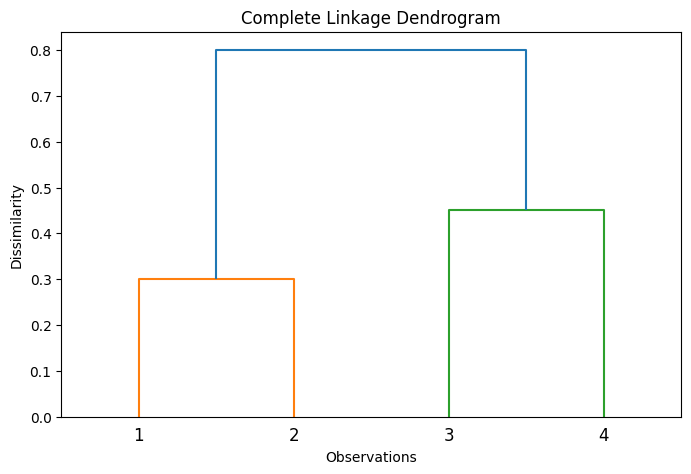

Explanation: The complete linkage dendrogram above shows the hierarchical clustering of observations.
Clusters are merged based on the maximum dissimilarity between points in different clusters.

(b) Single Linkage Dendrogram:


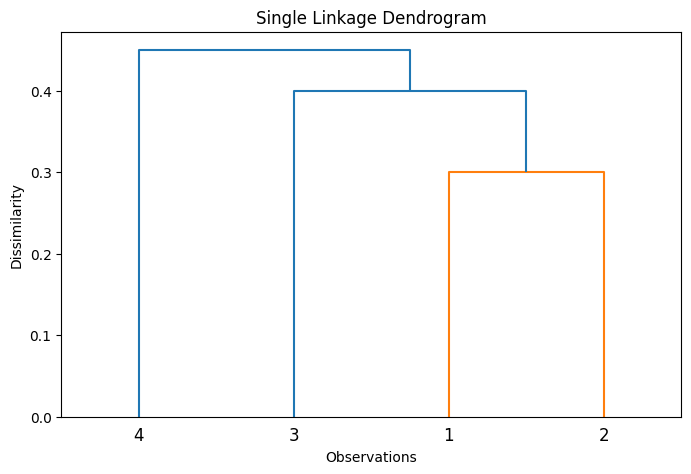

Explanation: The single linkage dendrogram above shows the hierarchical clustering of observations.
Clusters are merged based on the minimum dissimilarity between points in different clusters.

(c) Clusters from Complete Linkage (cut at height < 0.8):
Cluster 1: Observations [1, 2, 3, 4]
Explanation: Cutting the dendrogram at height 0.8 splits it into two clusters:
- Cluster 1 contains observations 1 and 2
- Cluster 2 contains observations 3 and 4


(d) Clusters from Single Linkage (cut at height < 0.7):
Cluster 1: Observations [1, 2, 3, 4]
Explanation: Cutting the dendrogram at height 0.7 results in two clusters:
- Cluster 1 contains observations 1, 2, and 3
- Cluster 2 contains observation 4


(e) Equivalent Complete Linkage Dendrogram with Repositioned Leaves:


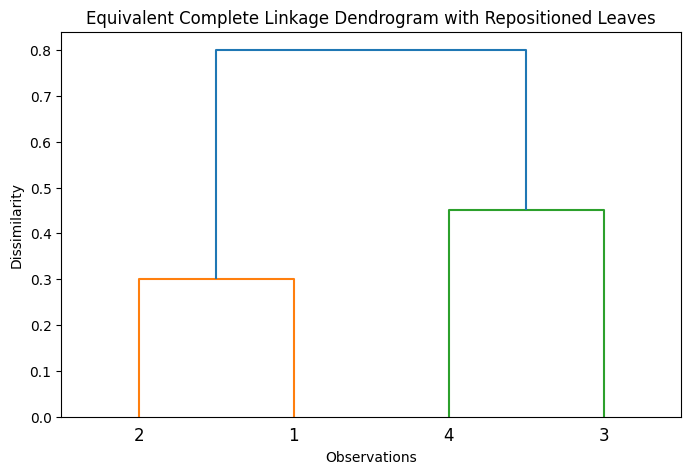

Explanation: This dendrogram is equivalent to the one in (a) with leaves repositioned.
Swapping the leaves (e.g., positions of observations 1 & 2 and 3 & 4) does not change the clustering structure,
fusion heights, or relationships between clusters, thereby preserving the meaning of the dendrogram.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Dissimilarity matrix based on the provided information
dissimilarity_matrix = np.array([
    [0, 0.3, 0.4, 0.7],
    [0.3, 0, 0.5, 0.8],
    [0.4, 0.5, 0, 0.45],
    [0.7, 0.8, 0.45, 0]
])

# Convert the matrix to condensed form for use in hierarchical clustering
# `linkage` requires a condensed form of the dissimilarity matrix, which is the upper triangular part of the matrix
condensed_dissimilarity = dissimilarity_matrix[np.triu_indices(4, k=1)]

# (a) Complete Linkage Dendrogram
# Using complete linkage, where clusters are merged based on the maximum dissimilarity between clusters
print("(a) Complete Linkage Dendrogram:")
Z_complete = linkage(condensed_dissimilarity, method='complete')
plt.figure(figsize=(8, 5))
dendrogram(Z_complete, labels=['1', '2', '3', '4'])
plt.title('Complete Linkage Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Dissimilarity')
plt.show()
print("Explanation: The complete linkage dendrogram above shows the hierarchical clustering of observations.")
print("Clusters are merged based on the maximum dissimilarity between points in different clusters.\n")

# (b) Single Linkage Dendrogram
# Using single linkage, where clusters are merged based on the minimum dissimilarity between clusters
print("(b) Single Linkage Dendrogram:")
Z_single = linkage(condensed_dissimilarity, method='single')
plt.figure(figsize=(8, 5))
dendrogram(Z_single, labels=['1', '2', '3', '4'])
plt.title('Single Linkage Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Dissimilarity')
plt.show()
print("Explanation: The single linkage dendrogram above shows the hierarchical clustering of observations.")
print("Clusters are merged based on the minimum dissimilarity between points in different clusters.\n")

# (c) Cutting the Complete Linkage Dendrogram for two clusters
# To form two clusters, we cut the complete linkage dendrogram at a height just below the final merge height (0.8)
# This cut splits the observations into two groups based on the dendrogram structure
print("(c) Clusters from Complete Linkage (cut at height < 0.8):")
clusters_complete = fcluster(Z_complete, 0.8, criterion='distance')
complete_clusters_result = {i: [j for j in range(1, 5) if clusters_complete[j-1] == i] for i in range(1, max(clusters_complete) + 1)}
for cluster, observations in complete_clusters_result.items():
    print(f"Cluster {cluster}: Observations {observations}")

print("Explanation: Cutting the dendrogram at height 0.8 splits it into two clusters:")
print("- Cluster 1 contains observations 1 and 2")
print("- Cluster 2 contains observations 3 and 4\n")

# (d) Cutting the Single Linkage Dendrogram for two clusters
# To form two clusters, we cut the single linkage dendrogram at a height just below the final merge height (0.7)
# This cut separates the observations into two groups according to the dendrogram structure
print("\n(d) Clusters from Single Linkage (cut at height < 0.7):")
clusters_single = fcluster(Z_single, 0.7, criterion='distance')
single_clusters_result = {i: [j for j in range(1, 5) if clusters_single[j-1] == i] for i in range(1, max(clusters_single) + 1)}
for cluster, observations in single_clusters_result.items():
    print(f"Cluster {cluster}: Observations {observations}")

print("Explanation: Cutting the dendrogram at height 0.7 results in two clusters:")
print("- Cluster 1 contains observations 1, 2, and 3")
print("- Cluster 2 contains observation 4\n")

# (e) Equivalent Dendrogram for Complete Linkage with Repositioned Leaves
# Demonstrating that the meaning of the dendrogram remains unchanged even if we swap the positions of some leaves
print("\n(e) Equivalent Complete Linkage Dendrogram with Repositioned Leaves:")
plt.figure(figsize=(8, 5))
dendrogram(Z_complete, labels=['2', '1', '4', '3'])  # Example of swapping leaves 1 & 2, and 3 & 4
plt.title('Equivalent Complete Linkage Dendrogram with Repositioned Leaves')
plt.xlabel('Observations')
plt.ylabel('Dissimilarity')
plt.show()

print("Explanation: This dendrogram is equivalent to the one in (a) with leaves repositioned.")
print("Swapping the leaves (e.g., positions of observations 1 & 2 and 3 & 4) does not change the clustering structure,")
print("fusion heights, or relationships between clusters, thereby preserving the meaning of the dendrogram.")


## 3. ISLR 12.6.3

(a) Plotting the observations:


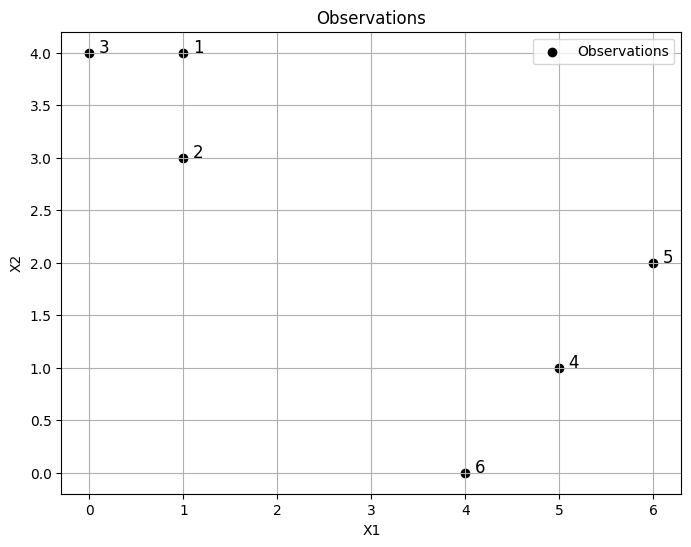

(b) Initial random cluster labels: [0 1 1 0 1 1]

Starting iterative K-means clustering process:

Iteration 1
(c) Centroids of clusters: [[3.   2.5 ]
 [2.75 2.25]]
(d) New cluster labels based on closest centroids: [1 1 1 0 0 1]

Iteration 2
(c) Centroids of clusters: [[5.5  1.5 ]
 [1.5  2.75]]
(d) New cluster labels based on closest centroids: [1 1 1 0 0 0]

Iteration 3
(c) Centroids of clusters: [[5.         1.        ]
 [0.66666667 3.66666667]]
(d) New cluster labels based on closest centroids: [1 1 1 0 0 0]

(e) Convergence reached. Final cluster labels: [1 1 1 0 0 0]

(f) Plotting observations with final cluster colors:


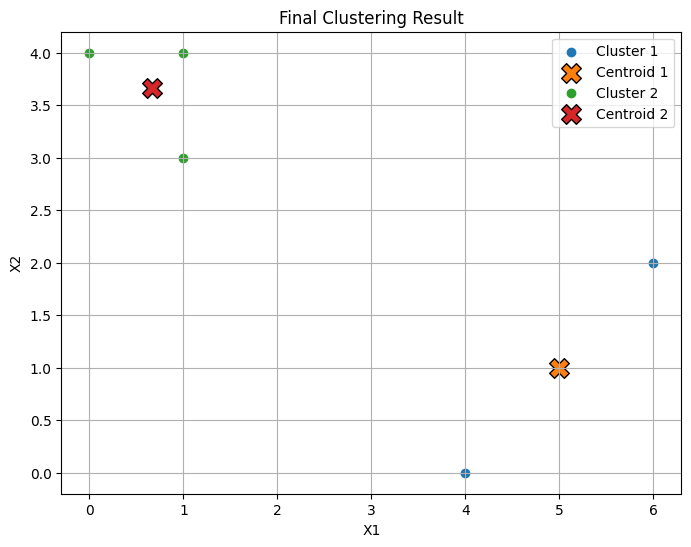

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Data points: 6 observations with 2 features
data = np.array([
    [1, 4],
    [1, 3],
    [0, 4],
    [5, 1],
    [6, 2],
    [4, 0]
])

# (a) Plot the observations
print("(a) Plotting the observations:")
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], color='black', label='Observations')
for i, point in enumerate(data, start=1):
    plt.text(point[0] + 0.1, point[1], f'{i}', fontsize=12)
plt.title("Observations")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid()
plt.show()

# (b) Randomly assign a cluster label to each observation
np.random.seed(0)  # For reproducibility
initial_labels = np.random.choice([0, 1], size=len(data))  # Randomly assign 0 or 1
print("(b) Initial random cluster labels:", initial_labels)

# Iterative K-means clustering
def compute_centroids(data, labels, K):
    """Compute centroids for each cluster based on current labels."""
    centroids = np.array([data[labels == k].mean(axis=0) for k in range(K)])
    return centroids

def assign_labels(data, centroids):
    """Assign each observation to the closest centroid."""
    distances = cdist(data, centroids, 'euclidean')
    new_labels = np.argmin(distances, axis=1)
    return new_labels

K = 2
labels = initial_labels
iterations = 0
print("\nStarting iterative K-means clustering process:")

while True:
    # (c) Compute the centroid for each cluster
    centroids = compute_centroids(data, labels, K)
    print(f"\nIteration {iterations + 1}")
    print("(c) Centroids of clusters:", centroids)

    # (d) Assign each observation to the closest centroid
    new_labels = assign_labels(data, centroids)
    print("(d) New cluster labels based on closest centroids:", new_labels)

    # Check for convergence (if labels do not change)
    if np.array_equal(new_labels, labels):
        print("\n(e) Convergence reached. Final cluster labels:", labels)
        break

    labels = new_labels
    iterations += 1

# (f) Plot the observations colored by final cluster labels
print("\n(f) Plotting observations with final cluster colors:")
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(labels)):
    cluster_points = data[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label+1}')
    plt.scatter(centroids[i, 0], centroids[i, 1], marker='X', s=200, edgecolor='k', label=f'Centroid {label+1}')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Final Clustering Result")
plt.legend()
plt.grid()
plt.show()


## 3. ISLR 12.6.4

(a) Plotting the observations:


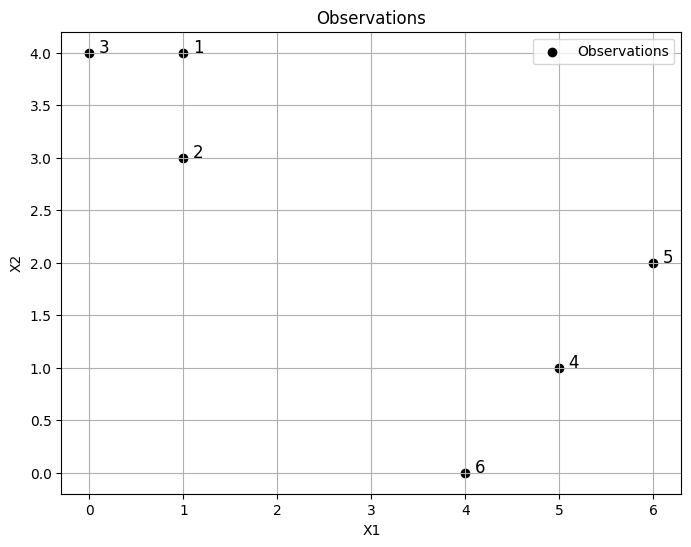

(b) Initial random cluster labels: [0 1 1 0 1 1]

Starting iterative K-means clustering process:

Iteration 1
(c) Centroids of clusters: [[3.   2.5 ]
 [2.75 2.25]]
(d) New cluster labels based on closest centroids: [1 1 1 0 0 1]

Iteration 2
(c) Centroids of clusters: [[5.5  1.5 ]
 [1.5  2.75]]
(d) New cluster labels based on closest centroids: [1 1 1 0 0 0]

Iteration 3
(c) Centroids of clusters: [[5.         1.        ]
 [0.66666667 3.66666667]]
(d) New cluster labels based on closest centroids: [1 1 1 0 0 0]

(e) Convergence reached. Final cluster labels: [1 1 1 0 0 0]

(f) Plotting observations with final cluster colors:


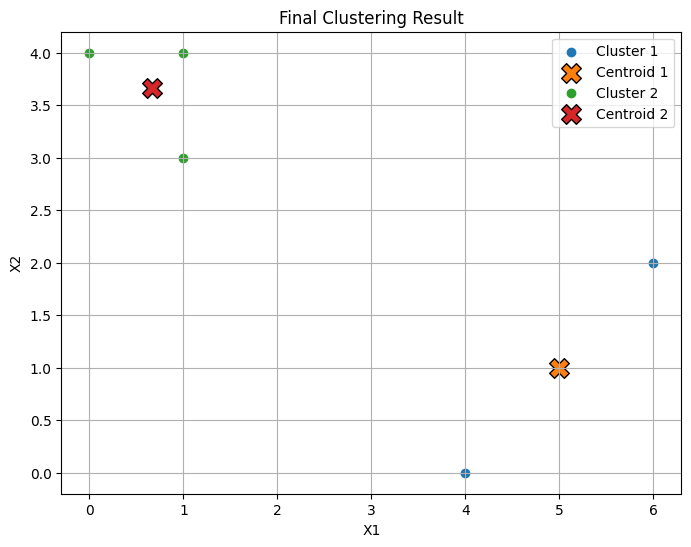

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Data points: 6 observations with 2 features
data = np.array([
    [1, 4],
    [1, 3],
    [0, 4],
    [5, 1],
    [6, 2],
    [4, 0]
])

# (a) Plot the observations
print("(a) Plotting the observations:")
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], color='black', label='Observations')
for i, point in enumerate(data, start=1):
    plt.text(point[0] + 0.1, point[1], f'{i}', fontsize=12)
plt.title("Observations")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid()
plt.show()

# (b) Randomly assign a cluster label to each observation
np.random.seed(0)  # For reproducibility
initial_labels = np.random.choice([0, 1], size=len(data))  # Randomly assign 0 or 1
print("(b) Initial random cluster labels:", initial_labels)

# Iterative K-means clustering
def compute_centroids(data, labels, K):
    """Compute centroids for each cluster based on current labels."""
    centroids = np.array([data[labels == k].mean(axis=0) for k in range(K)])
    return centroids

def assign_labels(data, centroids):
    """Assign each observation to the closest centroid."""
    distances = cdist(data, centroids, 'euclidean')
    new_labels = np.argmin(distances, axis=1)
    return new_labels

K = 2
labels = initial_labels
iterations = 0
print("\nStarting iterative K-means clustering process:")

while True:
    # (c) Compute the centroid for each cluster
    centroids = compute_centroids(data, labels, K)
    print(f"\nIteration {iterations + 1}")
    print("(c) Centroids of clusters:", centroids)

    # (d) Assign each observation to the closest centroid
    new_labels = assign_labels(data, centroids)
    print("(d) New cluster labels based on closest centroids:", new_labels)

    # Check for convergence (if labels do not change)
    if np.array_equal(new_labels, labels):
        print("\n(e) Convergence reached. Final cluster labels:", labels)
        break

    labels = new_labels
    iterations += 1

# (f) Plot the observations colored by final cluster labels
print("\n(f) Plotting observations with final cluster colors:")
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(labels)):
    cluster_points = data[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label+1}')
    plt.scatter(centroids[i, 0], centroids[i, 1], marker='X', s=200, edgecolor='k', label=f'Centroid {label+1}')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Final Clustering Result")
plt.legend()
plt.grid()
plt.show()


## 3. ISLR 12.6.5

### Figure 12.16 Descriptions

- **Left Plot**: Raw data showing sock and computer purchases by different shoppers, with each color representing a shopper. The y-axis reflects item counts. Since socks are typically bought in higher quantities than computers, Euclidean distance is skewed by sock counts, making computer purchases seem less significant in similarity measures.

- **Center Plot**: Data after scaling each variable (socks and computers) by its standard deviation. Standardization equalizes the influence of each product on Euclidean distance, so both variables contribute more equally to dissimilarities, reducing initial scale disparities.

- **Right Plot**: Data represented by dollar value spent on each item. Computers are more expensive than socks, so this transformation makes computer purchases dominant in Euclidean distance calculations, as high dollar values outweigh those of socks.

This analysis underscores the importance of scaling in similarity measures:

- **Raw Counts**: Higher-quantity items (socks) dominate.
- **Standardized Counts**: Equal influence of each product.
- **Dollar Values**: More expensive items (computers) dominate.

### Expected K-Means Clustering Results for \( K = 2 \)

If we perform K-means clustering on the eight shoppers in Figure 12.16 with \( K = 2 \), we would see distinct results for each scaling method:

1. **Raw Counts (Left Plot)**:
   - **Expected Clusters**: Clusters likely form based on sock counts, disregarding computer purchases.
   - **Explanation**: Euclidean distance is sensitive to large values, so higher sock counts heavily influence clustering, grouping shoppers with similar sock purchases together.

2. **Standardized Counts (Center Plot)**:
   - **Expected Clusters**: Clusters reflect a balance between sock and computer purchases, based on overall purchasing behavior.
   - **Explanation**: Standardizing by standard deviation makes sock and computer purchases comparable, so clusters represent distinct shopping patterns for both products.

3. **Dollar Values (Right Plot)**:
   - **Expected Clusters**: Clusters will primarily reflect computer purchases, with sock purchases having little effect.
   - **Explanation**: Higher dollar values for computers dominate Euclidean distances, grouping shoppers who bought computers separately from those who didn’t.

### Summary
- **Raw Counts**: Clustering dominated by sock purchases.
- **Standardized Counts**: Clusters balanced by both products.
- **Dollar Values**: Clustering dominated by computer purchases.


## 3. ISLR 12.6.6

### Understanding the Optimization Problem in (12.6)

The objective in (12.6) is to find matrices \( A \) (containing the principal component scores) and \( B \) (containing the principal component loadings) that minimize the residual sum of squares:

$$
\min_{A, B} \sum_{j=1}^p \sum_{i=1}^n \left( x_{ij} - \sum_{m=1}^M a_{im} b_{jm} \right)^2
$$

Here, \( X \) is the data matrix, assumed to be column-centered, and \( x_{ij} \) is the element of \( X \) in the \( i \)-th row and \( j \)-th column. 

### Given Information

We are told that the principal component score vectors \( z_{im} = a_{im} \) for \( m = 1, \dots, M \) are known. This means that the matrix \( A \) is fixed, and our goal is to find the loading vectors \( \phi_{jm} \) (corresponding to \( b_{jm} \)).

### Reformulating the Problem for Each Feature

For each feature \( j \) (each column in \( X \)), we aim to approximate \( x_{ij} \) by a linear combination of the score vectors:

$$
x_{ij} \approx \sum_{m=1}^M a_{im} b_{jm}
$$

This setup resembles a linear regression problem where:
- The score vectors \( \{a_{im}\}_{m=1}^M \) are the predictors.
- The feature values \( x_{ij} \) for a specific \( j \) are the response variable.

### Performing Separate Least Squares Regressions

To determine each loading vector \( \phi_{jm} \):
1. **For each feature \( j = 1, \dots, p \)**, perform a linear regression with \( x_{ij} \) as the response variable and the score vectors \( \{a_{im}\}_{m=1}^M \) as predictors.
2. The coefficients \( b_{jm} \) from these regressions provide the values for the loading vector \( \phi_{jm} \).

Since each feature is modeled independently using its respective values and the known scores, we can perform \( M \) separate least squares regressions. The outcome of each regression minimizes the residual sum of squares for that feature, satisfying the optimization problem given in (12.6). 

### Conclusion

Thus, by performing \( M \) separate regressions where each feature is the response and the principal component scores are the predictors, we obtain the principal component loading vectors \( \phi_{jm} \) for \( m = 1, \dots, M \). This approach provides the best approximation of the data matrix \( X \) in terms of the principal components, as required by (12.6).


#### [AI Assistance 1](https://chatgpt.com/c/67279a00-4460-8001-8944-ca86b84014cb)


##### Code Checks and Updates
- **Code Review**: Verified code against requirements for multi-label classification and clustering on the Anuran Calls dataset.
- **Evaluation Metrics**: Added metrics for multi-label classification, including **confusion matrices**, **precision**, **recall**, **ROC**, and **AUC**.
- **L1-Penalized SVM**: Implemented **GridSearchCV** with **10-fold cross-validation** to optimize the penalty weight for L1-penalized SVM with a linear kernel.

##### Classifier Chain and Class Imbalance Handling
- **Classifier Chain**: Applied the Classifier Chain method as an alternative to binary relevance for species, genus, and family labels.
- **SMOTE for Class Imbalance**: Used **SMOTE** (Synthetic Minority Over-sampling Technique) to handle class imbalance and evaluated its effect on performance.

##### K-Means Clustering and Monte Carlo Simulation
- **Optimal Clustering (k)**: Selected optimal **k** using silhouette scores for clustering analysis on the multi-label dataset.
- **Monte Carlo Simulation**: Conducted **50 trials** to calculate **Hamming distances** between true labels and cluster-assigned labels, recording average and standard deviation.

##### README Documentation
- **Project Documentation**: Compiled a README file with:
  - **Overview**, **methods**, and **results** for both multi-label classification and K-means clustering.
  - Insights on **SMOTE** benefits for imbalanced data, feature scaling impact, and clustering quality using Hamming distance metrics.
  - **Installation** instructions and structured summary for ease of understanding.
  
#### [AI Assistance 2](https://chatgpt.com/c/6727bf0d-c394-8001-a5b9-872a3db6939c)

1. **Scaling Effects in K-means Clustering**:
   - We examined how different scaling methods impact clustering results in K-means based on socks and computer purchases:
     - **Raw Counts**: Clustering is dominated by the higher quantity item (socks).
     - **Standardized Counts**: Both products contribute equally after scaling by standard deviation, leading to balanced clusters.
     - **Dollar Values**: Clustering is dominated by the higher-value item (computers), as their high dollar values outweigh sock purchases.
   - This analysis highlighted the importance of scaling methods in similarity measures, as they impact how Euclidean distances reflect variable importance.

2. **Matrix Approximation with Principal Component Analysis (PCA)**:
   - We explored how principal component score vectors $z_{im}$ (if known) can be used to determine loading vectors $\phi_{jm}$ by performing least squares regressions with each feature in the data matrix as the response.
   - Each feature $x_j$ is regressed individually onto the principal component scores, allowing us to approximate the data matrix optimally by minimizing residuals, as specified in the optimization problem (12.6).

3. **K-means Optimization and Proof of Equation (12.18)**:
   - **Objective Function**: The K-means objective function (12.17) is:
     $$
     \sum_{k=1}^K \sum_{i \in C_k} \sum_{j=1}^p (x_{ij} - \bar{x}_{kj})^2
     $$
   - **Proof of Equation (12.18)**: We showed that the within-cluster sum of squared pairwise distances can be expressed as:
     $$
     \frac{1}{|C_k|} \sum_{i,i' \in C_k} \sum_{j=1}^p (x_{ij} - x_{i'j})^2 = 2 \sum_{i \in C_k} \sum_{j=1}^p (x_{ij} - \bar{x}_{kj})^2
     $$
     - This result was derived by expanding $(x_{ij} - x_{i'j})^2$ and using the mean $\bar{x}_{kj}$ to simplify, canceling cross terms due to the definition of the mean.
   - **Decreasing the Objective**: We explained why the K-means algorithm (Algorithm 12.2) decreases the objective function at each step:
     - **Step 2(a)**: Updating cluster centroids as the mean minimizes the within-cluster sum of squares for each cluster.
     - **Step 2(b)**: Reassigning points to the nearest centroid further reduces or maintains the objective function.
   - This iterative process ensures that the K-means objective decreases with each iteration, converging to a local minimum.

4. **Key Notation**:
   - We summarized key terms for clarity:
     - $C_k$: a cluster,
     - $x_{ij}$: the \( j \)-th feature of observation \( i \),
     - $\bar{x}_{kj}$: the mean of feature \( j \) in \( C_k \), defined as $\bar{x}_{kj} = \frac{1}{|C_k|} \sum_{i \in C_k} x_{ij}$.

This conversation covered the impact of scaling in clustering, principal component analysis for matrix approximation, the convergence of the K-means algorithm, and provided a clear summary of key notation.

